# Predict students' graduation rate

dataset 
- [from @ roycekimmons.com](http://roycekimmons.com/tools/generated_data/graduation_rate)

> This is a fictional dataset and should only be used for data science training purposes.
> 
> This data set includes graduation rates from a four-year college with a variety of student factors.

The key questions we want to address:

> 1. How effective are entrance requirements at predicting gpa and graduation rate?
> 1. What would be the best way to improve graduation rates?

> All data sets are generated on-the-fly. So, you can increase your n by downloading a data set multiple times and combining the files. (n=1000) per large sample download

Based on the above statement, I have downloaded 5x times and combined them into one csv file so that we can work with a larger sample size of 5000 observations, instead of just 1000 observations.

Target is `'graduate_in_5years'` and column named simply as `'target'`
- feature-engineered from 'years_to_graduate' as 
  - 0: 'Yes' ie 'years_to_graduate' < 6
  - 1: 'No' ie 'years_to_graduate' > 5 
- was set to 4 years initially until EDA reveals median is 5.


In [1]:
import sys
from pathlib import Path
import logging
from contextlib import redirect_stdout

# Configure the logging library.
logging.basicConfig(filename='hyperparam_tuning.log', level=logging.INFO)

# Set the path to the current file 
current_file_path = Path().resolve()
print(f'{current_file_path = } ')

# Set the path to the data folder
data_folder_path = current_file_path / 'data'
print(f'{data_folder_path = } ')

# Set the path to the src folder
src_folder_path = current_file_path / 'src'
print(f'{src_folder_path = } ')

# Add the src folder to the system path
sys.path.append(str(src_folder_path))

# Import modules from files under /src
from config import * 
from src.data_loader import CSVDataLoader
from src.data_preprocessor import Preprocessor
from src.data_feature_builder import FeatureBuilder
from src.trainer import *
from src.predictor import *

current_file_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms') 
data_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/data') 
src_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/src') 


## Import packages

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import sklearn
sklearn.__version__

'1.2.2'

## Overview

> do we want 
> - 2 splits for train, test or 
> - 3 splits for train, val and test?
>
> reminder: 
> - not yet stratify
> - not scaled
> - use cross-validation 
> - save final df to file as processed_df.csv?

In this notebook, we're finally going to address the above questions. We're using 
- KFolds to cross-validate our data splitting,
- using just 3 features that were shown as the most important features via EDA
- scale our data, treat outliers using Pipelines,
- perform hyperparameters tuning on the 2 classifiers with highest `'val auc'` scores,
- finally, the final chosen "best model" would be identified, and 
- creating scripts out of our POC code would start, that would allow
- save our model to a `.pkl` file for our deployed model to a web servic.e


## Hyperparameters Tuning

### Putting it all together

Based on findings from baseline scoring, we're gonna limit our GridSearch and hyperparameters tuning to just these 2 classifiers.

Perform data preprocessing and use pipelines to perform hyperparameter tuning to a couple of the models from previous top 2 performers:

- HistGradientBoostingClassifier()
- CatBoostClassifier()


In [5]:
# declare the 3 features we using to train the model
features = ['parental_income', 'sat_total_score', 'college_gpa'] 
# graduate_in_5years simply labeled as 'target'
target_name = 'target'

In [6]:
# Data ingestion
data = CSVDataLoader().load('data/graduation_rate.csv')
print()

print("- Preprocessor()...")
data = Preprocessor().ColumnsSymbolReplacer(data)
data = Preprocessor().SymbolReplacer(data, 'parental_level_of_education')
# data = Preprocessor().OutliersTransformer(data, 0.05, 0.95) # need to be done before TargetEncoder(), that drop columns
print()
print("- FeatureBuilder()...")
data = FeatureBuilder().TargetEncoder(data)
# X, y = FeatureBuilder().ColVectorizer(data) # need to be done last, creates dv of X which is an array

target = data[target_name]
data = data[features]

Loading CSV data...


100%|██████████| 10/10 [00:00<00:00, 232.56it/s]

Finished processing the CSV file.
df.shape = (5000, 7)

- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...

- FeatureBuilder()...
  -- Creating 'target' column...


In [7]:
df_full_train, df_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=11)


INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU


### Hyperparams Tuning on HistGradientBoostingClassifier

#### setup

In [15]:
# initialize
scores = []
fold = 0

# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

hist_param_grid = {
    'classifier__learning_rate': LEARNING_RATE,
    'classifier__max_iter': MAX_ITER,
    'classifier__max_depth': MAX_DEPTH,
    'classifier__min_samples_leaf': MIN_SAMPLES_LEAF, 
    'classifier__early_stopping': ['auto', True],
    'classifier__class_weight': WEIGHTS
}

# Create the pipeline
pipe = Pipeline([
    ('outlier_treatment', QuantileTransformer() ),
    ('scaler',  StandardScaler() ),
    ('classifier', 
     HistGradientBoostingClassifier(verbose=5, scoring='f1_weighted', warm_start=True, random_state=42)
    )
])

# Create a GridSearchCV object
grid_search = GridSearchCV(
    pipe, 
    hist_param_grid, 
    cv=kfold, 
    error_score='raise', 
    return_train_score=True,
    refit=True,
    verbose=2,
    n_jobs=-1
)

#### train

In [16]:
%%capture output   
# Log the output of each step of the tuning process.
logging.info('Starting HistGradientBoostingClassifier hyperparam tuning...')

# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = target[train_idx].values
    y_val = target[val_idx].values
    
    logging.info(f'-- in grid_search.fit(); kfold: {fold} --')
    fold = fold + 1

    logging.info('Fitting GridSearchCV model...')
    with open('hyperparam_tuning.log', 'a') as f:
        with redirect_stdout(f):
            # Train the model on the train data
            grid_search.fit(df_train, y_train)
    logging.info('GridSearchCV fit completed')
    
# this cell took approx 45mins on my machine! 

#### predict

In [47]:
# Make predictions on the validate data
y_pred_train = grid_search.predict(df_train)
y_pred_val = grid_search.predict(df_val)

# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred_val),
    "accuracy": accuracy_score(y_val, y_pred_val),
    "precision": precision_score(y_val, y_pred_val),
    "f1_mean": f1_score(y_val, y_pred_val),
    "recall": recall_score(y_val, y_pred_val),   
    }
)
logging.info(f'-- HistGradientBoostingClassifier val scores appended --')

# Log the results of the tuning process.
logging.info('Finished HistGradientBoostingClassifier hyperparam tuning. The best hyperparameters are: {}'.format(grid_search.best_params_))

INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU


In [18]:
# logging.close()
print(f"The best set of parameters is: {grid_search.best_params_}")

The best set of parameters is: {'classifier__class_weight': None, 'classifier__early_stopping': True, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__max_iter': 100, 'classifier__min_samples_leaf': 10}


#### evaluate

[source](https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_parallel_plot.html) for `shorten_param` code snippet

In [19]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

In [20]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head(3).T

,527,524,530
mean_fit_time,0.1886,0.157999,0.146999
std_fit_time,0.059507,0.049444,0.039952
mean_score_time,0.0142,0.0106,0.0154
std_score_time,0.022903,0.015705,0.025303
param_classifier__class_weight,None,None,None
param_classifier__early_stopping,True,True,True
param_classifier__learning_rate,0.1,0.1,0.1
param_classifier__max_depth,8,8,8
param_classifier__max_iter,500,100,1000
param_classifier__min_samples_leaf,10,10,10


In [21]:
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,class_weight,early_stopping,learning_rate,max_depth,max_iter,min_samples_leaf,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
527,0.188600,0.059507,0.014200,2.290340e-02,None,True,0.1,8,500,10,...,0.710625,0.016250,1,0.708203,0.716797,0.717187,0.713672,0.716016,0.714375,0.003318
524,0.157999,0.049444,0.010600,1.570490e-02,None,True,0.1,8,100,10,...,0.710625,0.016250,1,0.708203,0.716797,0.717187,0.713672,0.716016,0.714375,0.003318
530,0.146999,0.039952,0.015400,2.530340e-02,None,True,0.1,8,1000,10,...,0.710625,0.016250,1,0.708203,0.716797,0.717187,0.713672,0.716016,0.714375,0.003318
456,0.135599,0.051875,0.003000,2.132481e-07,None,True,0.001,8,1000,2,...,0.709375,0.016477,4,0.703516,0.716016,0.710938,0.708984,0.707422,0.709375,0.004119
463,0.187999,0.074799,0.003800,1.165746e-03,None,True,0.001,12,500,5,...,0.709375,0.016477,4,0.703516,0.716016,0.710938,0.708984,0.707422,0.709375,0.004119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.230799,0.067027,0.003600,8.003476e-04,balanced,True,0.001,8,500,2,...,0.420312,0.074458,570,0.567187,0.503906,0.436328,0.467187,0.415625,0.478047,0.053609
163,0.173600,0.047081,0.003201,3.992400e-04,balanced,True,0.001,8,100,5,...,0.415937,0.081678,573,0.570312,0.526563,0.435156,0.434766,0.415234,0.476406,0.060847
166,0.213200,0.067128,0.003200,4.005436e-04,balanced,True,0.001,8,500,5,...,0.415937,0.081678,573,0.570312,0.526563,0.435156,0.434766,0.415234,0.476406,0.060847
169,0.215800,0.100181,0.003400,8.002043e-04,balanced,True,0.001,8,1000,5,...,0.415937,0.081678,573,0.570312,0.526563,0.435156,0.434766,0.415234,0.476406,0.060847


In [22]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'class_weight', 'early_stopping', 'learning_rate', 'max_depth',
       'max_iter', 'min_samples_leaf', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [23]:
cv_results = cv_results.sort_index()

<Axes: >

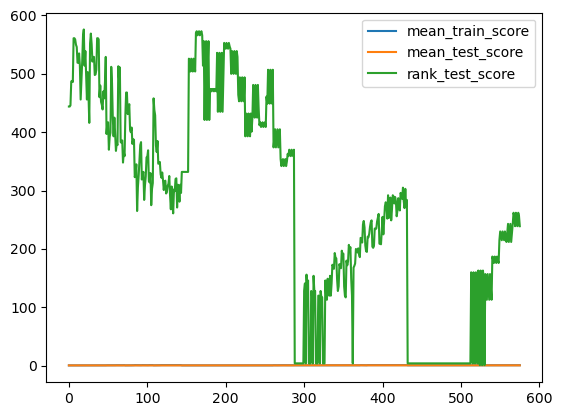

In [24]:
compare = cv_results[['mean_train_score', 'mean_test_score', 'rank_test_score']]
compare.plot()

In [25]:
# Displaying a Pipeline with a Preprocessing Step and Regression
from sklearn import set_config
set_config(display="diagram")

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('outlier_treatment',
                                        QuantileTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        HistGradientBoostingClassifier(random_state=42,
                                                                       scoring='f1_weighted',
                                                                       verbose=5,
                                                                       warm_start=True))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__early_stopping': ['auto', True],
                         'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'classifier__max_depth': [2, 6, 8, 12],
                         'classifier__max_iter': [100, 500, 1000],
                         'classifier__min_samples_leaf': [2, 5, 10]},
             return_train_score=True, verbose=2)

#### Best model training and prediction

In [26]:
# {'classifier__class_weight': None, 'classifier__early_stopping': True, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__max_iter': 100, 'classifier__min_samples_leaf': 10}

best_params = grid_search.best_params_
best_hist = HistGradientBoostingClassifier(best_params)

# best_hist = HistGradientBoostingClassifier(
#     class_weight=None, 
#     early_stopping=True, 
#     learning_rate=0.1, 
#     max_depth=8, 
#     max_iter=100, 
#     min_samples_leaf=10)
best_hist.fit(df_train, y_train)

y_pred_train = best_hist.predict(df_train)

# using unseen test data
y_test = y_test.values
y_pred_test = best_hist.predict(df_test)
# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred_test),
    "accuracy": accuracy_score(y_test, y_pred_test),
    "precision": precision_score(y_test, y_pred_test),
    "f1_mean": f1_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),   
    }
)
logging.info(f'-- best_hist test scores appended --')

INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU


### Hyperparams Tuning on CatBoostClassifier

#### setup

In [36]:
# initialize
fold = 0

# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cat_param_grid = {      
    'classifier__loss_function': ['Logloss', 'CrossEntropy'],
    'classifier__learning_rate': [0.001, 0.01, 0.1], # [0.001, 0.01, 0.1, 1.0]
    'classifier__depth': [6, 12], # [2, 6, 8, 12]
    'classifier__iterations': [100, 250], # [100, 250, 500, 750]
    'classifier__early_stopping_rounds': [5, 10, 20]
}

# Create the pipeline
pipe = Pipeline([
    ('outlier_treatment', QuantileTransformer() ),
    ('scaler',  StandardScaler() ),
    ('classifier', 
     CatBoostClassifier(
         verbose=5, 
         random_state=42, 
         eval_set=(df_val, y_val),)
    )
])

# Create a GridSearchCV object
grid_search = GridSearchCV(
    pipe, 
    cat_param_grid, 
    cv=kfold, 
    error_score='raise', 
    return_train_score=True,
    refit=True,
    verbose=5,
    n_jobs=-1
)


#### train

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

In [ ]:
 %%capture output
# Log the output of each step of the tuning process.
logging.info('Starting CatBoostClassifier hyperparam tuning...')

# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = target[train_idx].values
    y_val = target[val_idx].values
    
    logging.info(f'-- in grid_search.fit(); kfold: {fold} --')
    fold = fold + 1
    
    logging.info('Fitting GridSearchCV model...')
    with open('hyperparam_tuning.log', 'a') as f:
        with redirect_stdout(f):
            # Train the model on the train data
            grid_search.fit(df_train, y_train)
    
    logging.info('GridSearchCV fit completed')

# this cell took approx 45mins on my machine! 

#### predict

In [48]:
# Make predictions on the validation data
y_pred_train = grid_search.predict(df_train)
y_pred_val = grid_search.predict(df_val)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred_val),
    "accuracy": accuracy_score(y_val, y_pred_val),
    "precision": precision_score(y_val, y_pred_val),
    "f1_mean": f1_score(y_val, y_pred_val),
    "recall": recall_score(y_val, y_pred_val),   
    }
)
logging.info(f'-- CatBoostClassifier scores appended --')

# Log the results of the tuning process.
logging.info('Finished CatBoostClassifier hyperparam tuning. The best hyperparameters are: {}'.format(grid_search.best_params_))

INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU


In [39]:
grid_search.best_params_

{'classifier__depth': 6,
 'classifier__early_stopping_rounds': 5,
 'classifier__iterations': 100,
 'classifier__learning_rate': 0.001,
 'classifier__loss_function': 'Logloss'}

#### evaluate

In [40]:
cv_results2 = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results2.head().T

,0,27,29,30,31
mean_fit_time,0.610001,0.611599,0.6802,1.4018,1.330999
std_fit_time,0.038273,0.09382,0.064554,0.11941,0.074777
mean_score_time,0.004,0.003,0.01462,0.0128,0.007
std_score_time,0.001898,0.001096,0.02319,0.013363,0.00456
param_classifier__depth,6,6,6,6,6
param_classifier__early_stopping_rounds,5,20,20,20,20
param_classifier__iterations,100,100,100,250,250
param_classifier__learning_rate,0.001,0.01,0.1,0.001,0.001
param_classifier__loss_function,Logloss,CrossEntropy,CrossEntropy,Logloss,CrossEntropy
params,"{'classifier__depth': 6, 'classifier__early_st...","{'classifier__depth': 6, 'classifier__early_st...","{'classifier__depth': 6, 'classifier__early_st...","{'classifier__depth': 6, 'classifier__early_st...","{'classifier__depth': 6, 'classifier__early_st..."


In [41]:
cv_results2.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__depth', 'param_classifier__early_stopping_rounds',
       'param_classifier__iterations', 'param_classifier__learning_rate',
       'param_classifier__loss_function', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [42]:
cv_results2 = cv_results2.rename(shorten_param, axis=1)
cv_results2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,depth,early_stopping_rounds,iterations,learning_rate,loss_function,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.610001,0.038273,0.004000,0.001898,6,5,100,0.001,Logloss,"{'classifier__depth': 6, 'classifier__early_st...",...,0.709375,0.016477,1,0.703516,0.716016,0.710938,0.708984,0.707422,0.709375,0.004119
27,0.611599,0.093820,0.003000,0.001096,6,20,100,0.01,CrossEntropy,"{'classifier__depth': 6, 'classifier__early_st...",...,0.709375,0.016477,1,0.703516,0.716016,0.710938,0.708984,0.707422,0.709375,0.004119
29,0.680200,0.064554,0.014620,0.023190,6,20,100,0.1,CrossEntropy,"{'classifier__depth': 6, 'classifier__early_st...",...,0.709375,0.016358,1,0.706250,0.716797,0.714453,0.712891,0.711719,0.712422,0.003523
30,1.401800,0.119410,0.012800,0.013363,6,20,250,0.001,Logloss,"{'classifier__depth': 6, 'classifier__early_st...",...,0.709375,0.016477,1,0.703516,0.716016,0.710938,0.708984,0.707422,0.709375,0.004119
31,1.330999,0.074777,0.007000,0.004560,6,20,250,0.001,CrossEntropy,"{'classifier__depth': 6, 'classifier__early_st...",...,0.709375,0.016477,1,0.703516,0.716016,0.710938,0.708984,0.707422,0.709375,0.004119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,25.771800,2.054994,0.065400,0.031155,12,10,250,0.1,CrossEntropy,"{'classifier__depth': 12, 'classifier__early_s...",...,0.642188,0.015277,67,0.943359,0.939844,0.946094,0.950781,0.941016,0.944219,0.003917
47,26.181694,1.144153,0.067602,0.030421,12,5,250,0.1,CrossEntropy,"{'classifier__depth': 12, 'classifier__early_s...",...,0.642188,0.015277,67,0.943359,0.939844,0.946094,0.950781,0.941016,0.944219,0.003917
46,25.372126,1.328482,0.068600,0.023871,12,5,250,0.1,Logloss,"{'classifier__depth': 12, 'classifier__early_s...",...,0.642188,0.015277,67,0.943359,0.939844,0.946094,0.950781,0.941016,0.944219,0.003917
70,26.619204,1.627684,0.088799,0.033005,12,20,250,0.1,Logloss,"{'classifier__depth': 12, 'classifier__early_s...",...,0.642188,0.015277,67,0.943359,0.939844,0.946094,0.950781,0.941016,0.944219,0.003917


In [43]:
cv_results2 = cv_results2.sort_index()

<Axes: >

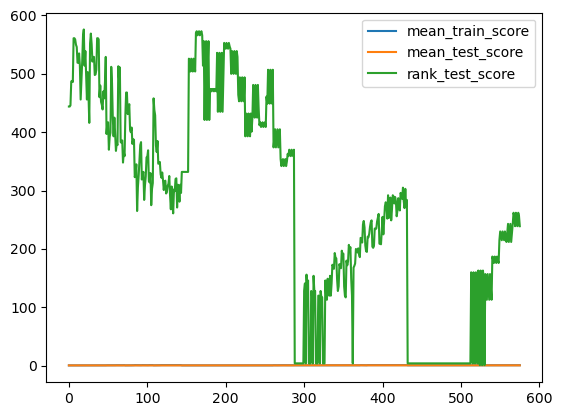

In [44]:
compare2 = cv_results2[['mean_train_score', 'mean_test_score', 'rank_test_score']]
compare.plot()

#### Best model training and prediction

In [50]:
grid_search.best_params_

{'classifier__depth': 6,
 'classifier__early_stopping_rounds': 5,
 'classifier__iterations': 100,
 'classifier__learning_rate': 0.001,
 'classifier__loss_function': 'Logloss'}

In [53]:
best_params = grid_search.best_params_
# best_cat = CatBoostClassifier(best_params)
best_cat = CatBoostClassifier(
    depth=6,
    early_stopping_rounds=5,
    iterations=100,
    learning_rate=0.001,
    loss_function='Logloss'    
)
best_cat.fit(df_train, y_train)

y_pred_train = best_cat.predict(df_train)
y_pred_test = best_cat.predict(df_test)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred_test),
    "accuracy": accuracy_score(y_test, y_pred_test),
    "precision": precision_score(y_test, y_pred_test),
    "f1_mean": f1_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),   
    }
)
logging.info(f'-- best_cat test scores appended --')

INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU


0:	learn: 0.6929660	total: 557us	remaining: 55.1ms
1:	learn: 0.6928025	total: 2.29ms	remaining: 112ms
2:	learn: 0.6926357	total: 3.4ms	remaining: 110ms
3:	learn: 0.6924727	total: 4.34ms	remaining: 104ms
4:	learn: 0.6923029	total: 5.28ms	remaining: 100ms
5:	learn: 0.6921329	total: 6.31ms	remaining: 98.8ms
6:	learn: 0.6919673	total: 7.82ms	remaining: 104ms
7:	learn: 0.6917995	total: 8.98ms	remaining: 103ms
8:	learn: 0.6916351	total: 10.1ms	remaining: 102ms
9:	learn: 0.6914665	total: 11.1ms	remaining: 99.6ms
10:	learn: 0.6913036	total: 13.7ms	remaining: 111ms
11:	learn: 0.6911401	total: 15.7ms	remaining: 115ms
12:	learn: 0.6909723	total: 17.3ms	remaining: 115ms
13:	learn: 0.6908072	total: 18.8ms	remaining: 116ms
14:	learn: 0.6906394	total: 21.5ms	remaining: 122ms
15:	learn: 0.6904763	total: 25.6ms	remaining: 134ms
16:	learn: 0.6903131	total: 26.8ms	remaining: 131ms
17:	learn: 0.6901515	total: 27.8ms	remaining: 127ms
18:	learn: 0.6899902	total: 29ms	remaining: 124ms
19:	learn: 0.6898274	to

INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU


## Final Model output

using df_test and the best_params

In [54]:
df = pd.DataFrame(scores)
df

,model,train auc,test auc,accuracy,precision,f1_mean,recall,val auc
0,HistGradientBoostingClassifier,0.506108,0.499657,0.7200,0.722362,0.836972,0.994810,NaN
1,HistGradientBoostingClassifier,0.505694,0.497914,0.7160,0.718154,0.834499,0.995828,NaN
2,CatBoostClassifier,0.500000,0.500000,0.7225,0.722500,0.838897,1.000000,NaN
3,CatBoostClassifier,0.500000,0.500000,0.7190,0.719000,0.836533,1.000000,NaN
4,HistGradientBoostingClassifier,0.500000,NaN,0.7225,0.722500,0.838897,1.000000,0.5
5,CatBoostClassifier,0.500000,NaN,0.7225,0.722500,0.838897,1.000000,0.5
6,CatBoostClassifier,0.500000,0.500000,0.7190,0.719000,0.836533,1.000000,NaN
